In [1]:
directory = '/Users/davidkarapetyan/Documents/workspace/data_analysis/'
csv_file = 'data/park345_steam.csv'

import pandas as pd
# for wide terminal display of pandas dataframes
pd.options.display.width = 120
pd.options.display.max_rows = 10000
import numpy as np
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.statespace.sarimax as sarimax

# plot inline
%pylab inline
# IPython.get_ipython().magic('matplotlib inline')
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 14, 6


# load dataframe, and subset out relevant columns
park_data = pd.read_csv(directory + csv_file, error_bad_lines=False)
park_data.columns = ['ID', 'TIMESTAMP',
'TRENDFLAGS', 'STATUS',
'VALUE', 'TRENDFLAGS_TAG',
'STATUS_TAG']
park_data = park_data.sort('TIMESTAMP')


# construct time series, getting rid of microseconds
park_ts = pd.Series(list(park_data.VALUE),
pd.DatetimeIndex(park_data.TIMESTAMP),
name="steam values")

park_ts = park_ts.loc[park_ts != 0].resample('15Min ').interpolate()
print(park_ts)

Populating the interactive namespace from numpy and matplotlib
2013-03-20 08:30:00     94.000000
2013-03-20 08:45:00     99.500000
2013-03-20 09:00:00    104.699997
2013-03-20 09:15:00    109.650002
2013-03-20 09:30:00    114.849998
2013-03-20 09:45:00    120.050003
2013-03-20 10:00:00    124.949997
2013-03-20 10:15:00    130.000000
2013-03-20 10:30:00    134.949997
2013-03-20 10:45:00    139.899994
2013-03-20 11:00:00    144.699997
2013-03-20 11:15:00    149.600006
2013-03-20 11:30:00    154.250000
2013-03-20 11:45:00    158.600006
2013-03-20 12:00:00    162.750000
2013-03-20 12:15:00    167.000000
2013-03-20 12:30:00    171.250000
2013-03-20 12:45:00    175.449997
2013-03-20 13:00:00    179.550003
2013-03-20 13:15:00    183.449997
2013-03-20 13:30:00    187.500000
2013-03-20 13:45:00    191.500000
2013-03-20 14:00:00    195.500000
2013-03-20 14:15:00    199.600006
2013-03-20 14:30:00    203.649994
2013-03-20 14:45:00    207.550003
2013-03-20 15:00:00    211.550003
2013-03-20 15:15:00

In [2]:
print(arima.ARIMA(park_ts, (0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                31550
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -163594.427
Method:                           css   S.D. of innovations             43.220
Date:                Mon, 20 Jul 2015   AIC                         327192.854
Time:                        13:14:15   BIC                         327209.572
Sample:                    03-20-2013   HQIC                        327198.205
                         - 02-12-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0043      0.243      0.018      0.986        -0.473     0.481


We see that ARIMA is not currently fitting the time series data. We look for an appropriate transformation of the time series to improve our ARIMA fitting.

###Log Ratio Transformation

To get a properly scaled plot, we filter out the outlier values occuring at
the end of day (shift from some steam usage to none at all as systems
restart, and spikes from ramp-up time at the beginning of the day).

count    31550.000000
mean         0.000028
std          0.638965
min         -7.981562
5%           0.000906
50%          0.032441
95%          0.234840
max          2.079442
Name: steam values, dtype: float64


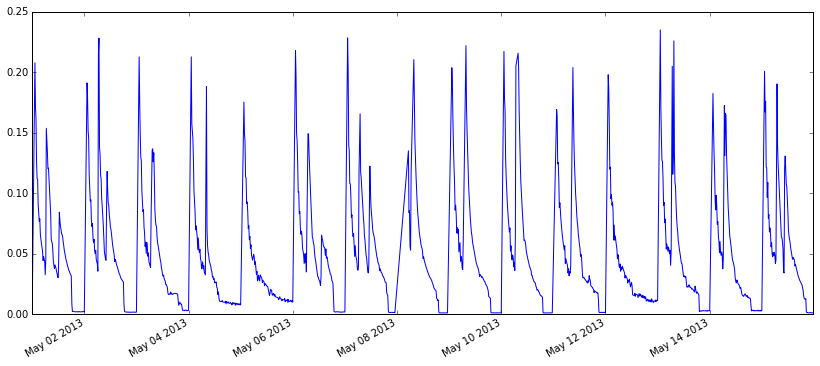

In [3]:
park_ts_logr = (np.log(park_ts / park_ts.shift(1)))[1:]
basic_stats = park_ts_logr.describe(percentiles=[0.05, 0.95])

print(basic_stats)
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-01': '2013-05-15'].plot()

The seasonality is clear. We now plot a single day, filtering out
outliers to get a properly scaled figure.

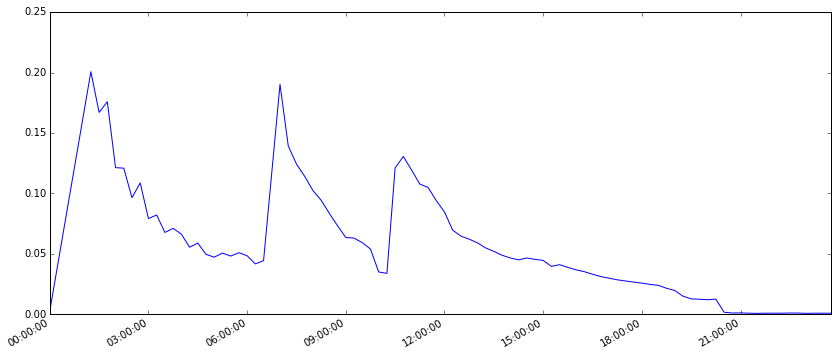

In [4]:
park_ts_logr[park_ts_logr.between(basic_stats['5%'], 
              basic_stats['95%']
             )]['2013-05-15'].plot()

Next, we utilise a SARIMAX model, with seasonality at 96
(our data points are spaced at 15 minute intervals),
and analyze a week's worth of data (starting on Monday, and ending on Friday).

In [5]:
print(sarimax.SARIMAX(park_ts_logr.loc['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  480
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood                -386.589
Date:                            Mon, 20 Jul 2015   AIC                            777.178
Time:                                    13:14:17   BIC                            785.526
Sample:                                05-06-2013   HQIC                           780.460
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.0905      0.050     -1.796      0.073        -0.189     0.008
sigma2         0.4385      0.031     14.183      0.000         0.378     0.499


While the fit isn't terrible, it perhaps can be improved by first observing
that we have spikes in our at the beginning of the day. This is due to
the ratio of consecutive values dipping suddenly at the end of day
as systems are ramped down.
Observe that the only negative values in the data occur at the start of
day. We filter these out, and re-run SARIMA.

In [6]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > basic_stats['5%']]['2013-05-06':'2013-05-10'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                  423
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                  77.908
Date:                            Mon, 20 Jul 2015   AIC                           -151.816
Time:                                    13:14:19   BIC                           -143.721
Sample:                                05-06-2013   HQIC                          -148.618
                                     - 05-10-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.5073      0.044     11.470      0.000         0.421     0.594
sigma2         0.0364      0.003     12.388      0.000         0.031     0.042


The positives of smoothing the data via filtration have been outweighed by the loss of data points to fit.  

Now, let's use a larger input
(beginning on a Monday, and ending on a Friday), and fit another
Sarimax model to our beginning-of-day spike-filtered data.

In [7]:
print(sarimax.SARIMAX(
park_ts_logr[park_ts_logr > 0]['2013-05-06':'2013-06-07'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 3114
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                3473.586
Date:                            Mon, 20 Jul 2015   AIC                          -6943.172
Time:                                    13:14:23   BIC                          -6931.085
Sample:                                05-06-2013   HQIC                         -6938.833
                                     - 06-07-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.5755      0.012     48.904      0.000         0.552     0.599
sigma2         0.0059      0.000     39.711      0.000         0.006     0.006


As expected, this is an even better fit than the fit for the week's worth of data.
Lastly, we input three # months worth of data, beginning on a Monday,
and ending on a Friday.

In [8]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr > 0]['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 8913
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                9949.323
Date:                            Mon, 20 Jul 2015   AIC                         -19894.646
Time:                                    13:14:31   BIC                         -19880.455
Sample:                                05-06-2013   HQIC                        -19889.815
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.5910      0.007     86.515      0.000         0.578     0.604
sigma2         0.0061   9.53e-05     64.324      0.000         0.006     0.006


Let's contrast this with our fit when we include the end-of-day spikes:

In [9]:
print(sarimax.SARIMAX(park_ts_logr['2013-05-06': '2013-08-08'],
seasonal_order=(0, 1, 0, 96)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 9120
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 96)   Log Likelihood                -943.988
Date:                            Mon, 20 Jul 2015   AIC                           1891.976
Time:                                    13:15:19   BIC                           1906.213
Sample:                                05-06-2013   HQIC                          1896.818
                                     - 08-08-2013                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.0797      0.010     -7.643      0.000        -0.100    -0.059
sigma2         0.0722      0.001     66.821      0.000         0.070     0.074


Hence, it makes sense to keep the analysis of
15-minute ramp-up and ramp-down times separate from the analysis of the remaining data.

##SARIMAX on Data for Individual Days

We next investigate seasonality on a weekly basis. That is, we
isolate the 5-day workweek into 5 chunks, and run SARIMAX on
each chunk separately.

In [10]:
print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 1,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 2,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 3,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 4,
park_ts_logr > basic_stats['5%'])],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4287
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood                4027.369
Date:                            Mon, 20 Jul 2015   AIC                          -8050.738
Time:                                    13:15:32   BIC                          -8038.012
Sample:                                03-25-2013   HQIC                         -8046.243
                                     - 02-10-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1          0.5912        nan        nan        nan           nan       nan
sigma2         0.0086      0.000     44.292      0.000         0.008     0.009
                                 Statespace Mod

Including the spikes gives:

In [11]:
print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 0],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 1],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 2],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 3],
seasonal_order=(0, 1, 0, 95)).fit().summary())

print(sarimax.SARIMAX(park_ts_logr[park_ts_logr.index.weekday == 4],
seasonal_order=(0, 1, 0, 95)).fit().summary())

                                 Statespace Model Results                                 
Dep. Variable:                       steam values   No. Observations:                 4512
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 95)   Log Likelihood               -4688.810
Date:                            Mon, 20 Jul 2015   AIC                           9381.620
Time:                                    13:16:22   BIC                           9394.449
Sample:                                03-25-2013   HQIC                          9386.140
                                     - 02-10-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1         -0.4921      0.013    -37.861      0.000        -0.518    -0.467
sigma2         0.4893      0.010     47.767      0.000         0.469     0.509
                                 Statespace Mod

##ARIMAX For Ramp-up and Ramp-Down

We shall treat Monday ramp-ups separately from the remaining days of the week,
due to difference between system-idling over weekends and weekdays.

In [12]:
print(arima.ARIMA(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)],
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                   51
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -92.965
Method:                           css   S.D. of innovations              1.498
Date:                Mon, 20 Jul 2015   AIC                            189.931
Time:                        13:16:59   BIC                            193.794
Sample:                    04-01-2013   HQIC                           191.407
                         - 02-10-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0152      0.210      0.073      0.942        -0.396     0.426


Observe that between end of day and start of day, chilled water temperature
decreases, and so $$\frac{T_k(0 + 00:15)}{T_k(0)} = a_k < 1$$ for each
entry in our training set. The set $\{a_k\}_k$ will hopefully consist of
entries that are clustered near one another, with some reasonable volatility.
Taking a logarithm of them will result in an exponential increase in
volatility, since $log(x)$ is an exponential function of $x$ for decreasing
$x < 1$. This will result in decreasing the goodness-of-fit of a linear
model, from a least-squares standpoint. Consequently, we exponentiate our
time series data, and re-fit:

In [13]:
print(arima.ARIMA(np.exp(park_ts_logr[np.logical_and(park_ts_logr.index.weekday == 0,
park_ts_logr < 0)]),
order=(0, 1, 0)).fit().summary())

                             ARIMA Model Results                              
Dep. Variable:         D.steam values   No. Observations:                   51
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  21.361
Method:                           css   S.D. of innovations              0.159
Date:                Mon, 20 Jul 2015   AIC                            -38.721
Time:                        13:16:59   BIC                            -34.858
Sample:                    04-01-2013   HQIC                           -37.245
                         - 02-10-2014                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0002      0.022      0.007      0.995        -0.044     0.044


Observe that the fit has improved.